In [1]:
import sys
import os
import time
sys.path.insert(0, '/mnt/cbis/home/amandakau/pyReCoDe')
from pyrecode.recode_reader import ReCoDeReader

import multiprocessing
import queue
import numpy as np
import matplotlib.pyplot as plt

This ReCoDeViewer class contains a master process that continuously checks if part files have been fully read, and if not, assigns batches of frames into a job queue. From there, multiprocessing is employed to do the jobs quickly to sum the frames together. __ReCoDeViewer only needs to be initialised and started to obtain an aggregate of all available part files (see below).__

In [2]:
class ReCoDeViewer:
    def __init__(self, folder_path, file_name, num_parts, batch_size=60):
        self._folder_path = folder_path
        self._file_name = file_name
        self._num_parts = num_parts
        self._batch_size = batch_size
        
        self._part_files = self._create_parts()
    
    def _create_parts(self):
        """ Returns a dictionary of part files as the following:
        { file_index: { file: ReCoDeReader, name: 'filename', shape: (ny, nx), is_read: True/False } }
        """
        
        file_dict = {}
        
        for index in range(self._num_parts):
            part_file_name = os.path.join(self._folder_path, self._file_name + '_part' + '{0:03d}'.format(index))
            reader = ReCoDeReader(part_file_name, is_intermediate=True)
            reader.open(print_header=False)
            header = reader.get_header().as_dict()
            
            #Dictionary to store file data
            part_file_info = {}
            part_file_info['file'] = reader
            part_file_info['name'] = part_file_name
            part_file_info['shape'] = (header['ny'], header['nx'])
            part_file_info['is_read'] = False
            file_dict[index] = part_file_info
            
        return file_dict
    
    def get_info(self):
        for index in self._part_files.keys():
            name =  self._part_files[index]['name']
            shape = self._part_files[index]['shape']
            print(f'File {name} with shape {shape} is being read.')
    
    def get_next_batch(self, part_file_id):
        """Fetches the next batch_size (60) frames from one specified part file and returns an array.
        """
        
        count = 0
        batch_data = []
        reader = self._part_files[part_file_id]['file']
        
        while count < self._batch_size:
            frame_data = reader.get_next_frame()
            
            if frame_data is None:
                self._part_files[part_file_id]['is_read'] = True
                break
            else:
                batch_data.append(frame_data)
                count += 1
        
        return batch_data
    
    def sum_frames(self, batch_data, part_file_id, plot_batch, final_result):
        """Returns an array describing containing the sum of all frames within the batch.
        Also adds sum of this batch to the total sum for this part file in final_result.
        
        plot_batch: True/False if sum of batch_size (60) frames should be plotted
        """
        
        shape = self._part_files[part_file_id]['shape'] # (ny, nx)
        summed_frame = np.zeros(shape[1], shape[0]) # (nx, ny)
        
        for frame in batch_data:
            frame_id = list(frame.keys())[0]
            summed_frame = np.add(summed_frame, frame[frame_id]['data'].toarray())
                
        #Save result
        if part_file_id not in final_result:
            final_result[part_file_id] = summed_frame
        else:
            final_result[part_file_id] = np.add(final_result[part_file_id], summed_frame)
        
        #and plot (if applicable)
        if plot_batch:
            self.plot_frame(summed_frame, part_file_id, self._batch_size)

        return summed_frame
    
    def combine_part_files(self, final_result):
        """Returns aggregate array of all existing part files from final_result.
        """
        
        shape = self._part_files[0]['shape']
        summed_frame = np.zeros(shape[1], shape[0])
        
        for index in range(self._num_parts):
            if index not in final_result:
                break
                
            #If the image in the part file has different dimensions, skip this part file
            elif np.shape(final_result[index]) != shape:
                print(f'Part file #{index} does not have the same dimensions - cannot be aggregated.')
                break

            summed_frame = np.add(summed_frame, final_result[index])
        
        return summed_frame
    
    def plot_frame(self, frame, part_file_id, num_frames):
        fig, ax = plt.subplots(1, 1, figsize=(20,10))
        im = ax.imshow(frame, vmax=np.amax(frame))
        if (part_file_id == -1) and (num_frames == 0):
            ax.set(title = 'Showing aggregate image sum of all part files combined')
        else:
            ax.set(title = f'Showing sum of {num_frames} frames from part file #{part_file_id}')
        fig.colorbar(im)
        plt.show()

    def start(self, plot_batch=False, plot_result=True, num_threads=4, plot_intermediate=False, interval=50):
        """Starts the master process that continuously checks if all part files have been read, and assigns jobs to a queue to be processed.
        Returns array containing the aggregate sum of all part files.
        
        Parameters:
        plot_batch: True if want sums of batch_size (60) frames to be plotted after each job is completed
        plot_result: True if want the final aggregate sum of all part files to be plotted
        num_threads: Number of processes
        plot_intermediate: True if want data to be plotted every n-th iteration, where n is specified in 'interval'
        interval: n, where data is aggregated and plotted every n-th iteration
        """
        start = time.time()
        is_completed = False
        iteration = 0
        
        job_ids = queue.Queue()
        job_queue = multiprocessing.Queue()
        manager = multiprocessing.Manager()
        final_result = manager.dict()
        
        while not is_completed:
            processes = []
            num_files_done = 0
            
            for index in range(self._num_parts):
                if (self._part_files[index]['is_read'] == False): #There's still a job to do
                    data = self.get_next_batch(index)
                    #self._queue.put(data)
                    job_queue.put(data)
                    job_ids.put(index)
                else:
                    num_files_done += 1
                    if (num_files_done == self._num_parts):
                        is_completed = True
            
            for i in range(num_threads):
                p = multiprocessing.Process(target=ReCoDeViewer.sum_frames, args=(self, job_queue.get(),
                                                                                  job_ids.get(), plot_batch, final_result))
                processes.append(p)
                p.start()
            
            for p in processes:
                p.join()
                p.terminate()
            
            iteration += 1
            if (iteration % interval == 0):
                print(f"Time elapsed (Iteration #{iteration}): {time.time()-start} seconds")
                if plot_intermediate:
                    agg = self.combine_part_files(final_result)
                    self.plot_frame(agg, -1, 0)

            del processes
            
        #Compute and plot aggregate image sum of all part files
        print("Getting aggregate...")
        agg_frame = self.combine_part_files(final_result)
        if plot_result:
            self.plot_frame(agg_frame, -1, 0)
        print(f"Total time elapsed: {time.time()-start} seconds")
            
        return agg_frame

In [3]:
_data_folder = '/scratch/loh/abhik/2Sep2020/captures/'
_tag = 'streampix_2k_60fps_run_4'
_num_part_files = 10

viewer = ReCoDeViewer(_data_folder, _tag + '.rc1', _num_part_files)

Time elapsed (Iteration #50): 393.0433430671692 seconds
Time elapsed (Iteration #100): 910.5397319793701 seconds
Time elapsed (Iteration #150): 1427.1555173397064 seconds
Time elapsed (Iteration #200): 1902.6676092147827 seconds
Time elapsed (Iteration #250): 2388.5991473197937 seconds
Time elapsed (Iteration #300): 2917.7298245429993 seconds
Time elapsed (Iteration #350): 3473.484920978546 seconds
Getting aggregate...


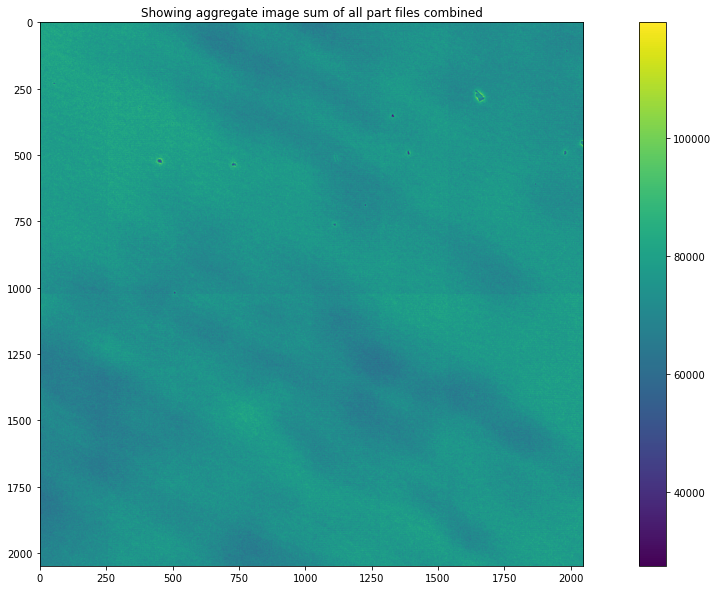

Total time elapsed: 3952.6070704460144 seconds


array([[87433, 80573, 82095, ..., 65356, 69624, 71266],
       [86586, 84754, 77000, ..., 76976, 64513, 71705],
       [75122, 77925, 78874, ..., 77934, 79064, 77167],
       ...,
       [71724, 65591, 70913, ..., 82415, 77814, 86937],
       [63516, 64917, 80506, ..., 79276, 81498, 81262],
       [65220, 66870, 69097, ..., 81601, 86204, 75807]], dtype=uint32)

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 410, in _send_bytes
    self._send(buf)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 416, in _se

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/c

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 416, in 

  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/c

BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multi

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 416, in 

BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multi

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(se

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connect

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(se

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in _send_bytes
    self._send(header)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/amandakau/miniconda3/lib/python3.9/multiprocessing/connection.py", line 409, in 

BrokenPipeError: [Errno 32] Broken pipe


In [4]:
viewer.start()